In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable
import six

using Zeng radius model
R_p = 1.0070000000000001 R_E
g_sfc = 9.68348870006869 m s^-2
CRF = 0.55
M_p 1.00 M_E
M_mantle 0.70 M_E
T_s 279.26 K
Q_cmb 0.00 TW


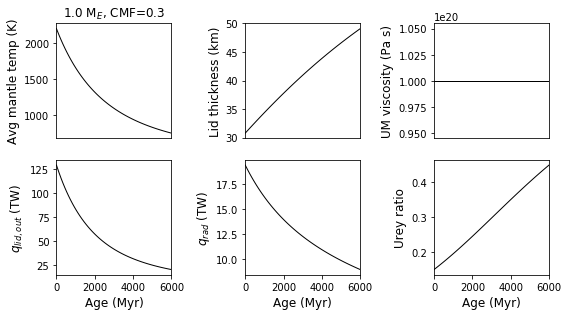

In [79]:
""" 0-D time-dependent forward model, isoviscous mantle """

M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope at tau=0 in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

L=1 # stellar luminosity in solar units
Alb=0
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 4500 # Density of silicate mantle in kg m^-3
#what is the right mantle density? low P highP?
#when doing these simple scalings, knowing the rock properties vary as a f(pt) 
#what p,t do we take the property at?

Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W

# thermo/geodynamic parameters
eta_m = 10**20 # Pa s, constant, actually eta... i.e. not kinematic viscosity but the other one
Ra_c = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
c_pm = 1200 # in Dorn, Noack & Rozal 2018
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
# can you use the same c_pm for lid and mantle?
# check if this is the right value for constant volume heat capacity
alpha_m = 2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1




def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_v(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_basic(M_p, CRF, rho_m, rho_c):
    """Calculate radius of planet given total mass, assume lid (bndy layer) has the same density as mantle
    
    Parameters
    ----------
    M_p : float
        Mass of planet
    rho_m : float
        Mantle density
    F_c : float
        Core fraction in terms of radius
    rho_c : float
        Core density
    """
    
    R_p = ( 3*M_p/(4*np.pi) / (rho_m - CRF**3*rho_m + CRF**3*rho_c) )**(1/3)
    return R_p

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    #print('kappa', k/(rho*C_p), 'm^2 s^-1')
    return k/(rho*C_p)

def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

def init(k_m=None, rho_m=None, rho_c=None, c_pm=None, CMF=None, M_p=None, **kwargs):
    R_p = radius_zeng(M_p, CMF)*R_E # in m
    print('R_p =', R_p/R_E, 'R_E')
    M_m = M_p*(1 - CMF) # mass of mantle
    CRF = CMF**0.5 # Zeng & Jacobsen 2017
    R_c = R_p*CRF
    #R_c = radius_seager(M_p*CMF, CMF=0, m1=4.34*M_E, r1=2.23*R_E) # EoS for iron... is this consistent?
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    g_sfc = grav(M_p, R_p)
    print('g_sfc =', g_sfc, 'm s^-2')
    print('CRF =', '%.2f'%CRF)
    kappa_m = thermal_diffusivity(k_m, rho_m, c_pm)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g=g_sfc, R_p=R_p, R_c=R_c)

def Ra(nu=None, kappa=None, alpha=None, rho=None, g=None, deltat=None, l=None):
    return rho*alpha*deltaT*l**3*g/(kappa*nu)

def lid_thickness(T_s=None, T_m=None, Ra_c=None, eta=None, alpha_m=None, rho_m=None, g=None, **kwargs):
    """Thickness of uppper mantle thermal boundary layer 
    
    Parameters
    ----------
    T_s : float
        Surface temperature
    Ra_c : float
        Critical Rayleigh number
    alpha_m : float 
        Thermal expansivity in
    kappa : float 
        Thermal diffusivity in
    eta : float
        Mantle viscosity in Pa s
    g : float
        Acceleration due to gravity in m s^-2
    
        
    Returns
    -------
    d : float
        Lid thickness in m
    """
    
    kappa_m=thermal_diffusivity(k_m, rho_m, c_pm)
    
    # Set Rayleigh number at critical value
    d = (Ra_c * eta_m*kappa_m/(alpha_m*rho_m*g*(T_m - T_s)))**(1/3)
    return d

def visc(T=None, eta_0=None, visc_type=None, **kwargs):
    if visc_type=='const':
        return [eta_0]*len(T)
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)

def nu_Dorn(T, nu_0=1.6e20, Ea=300e3, T_0=1800, **kwargs):
    # viscosity (below lithosphere) from Dorn, Noack & Rozal 2018
    return nu_0*np.exp(Ea/R_b*(T**-1-T_0**-1))

def nu_KW(T, p=0, **kwargs): # Karato & Wu 1993, diffusion law for dry olivine
    return 2.6e10*np.exp((3e5 + (6e3*p))/(R_b*T))   

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def h_rad(t=None, tf=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
        
def Q_rad(t=None, M_m=None, c_v=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    #print('h =', h, 'W kg^-1 @ t =',t*1e-6/years2sec, 'Myr')
    return h*M_m # mass cancels out

def Q_cmb(q_cmb=None, SA_c=None, M_m=None, c_v=None, **kwargs):
    """Calculate energy flux from core in W"""
    SA_c_Earth = SA(R=3480e3)
    q_cmb = Q_cmb_Earth/(4*np.pi*SA_c_Earth**2) # Heat flux across CMB in W m^-2, use earth value for now
    return q_cmb*SA_c
    
def Q_cond(T_m=None, T_s=None, k_m=None, M_m=None, c_v=None, SA_p=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W"""
    eta_um = visc(T_m, **kwargs) # upper mantle viscosity (non-kinematic)
    d_lid = lid_thickness(T_m=T_m, T_s=T_s, eta=eta_um, **kwargs)
    return SA_p*k_m*(T_m - T_s)/d_lid 
    
def dTdt(t, T_m, Q_core=None, M_m=None, c_v=None, **kwargs):
    """R.H.S. of ODE for mantle temperature change"""
    #print('t, T_m', t, T_m)
    return (-Q_cond(T_m=T_m, **kwargs) + Q_rad(t, **dict(M_m=M_m), **kwargs) + Q_core)/(M_m*c_v)

def solve_Tm(tf=None, T_m0=None, t0=0, plots=False, plots_save=False, fend='', M_p=None, **kwargs):
    derargs = init(M_p=M_p, **kwargs)
    q_out = q_sfc_outgoing(**derargs, **kwargs)
    T_s = T_sfc(q_out)
    Q_core = Q_cmb(**derargs, **kwargs)
    M_ME = M_p/M_E
    M_mME = derargs['M_m']/M_E
    print('M_p', '%.2f'%M_ME, 'M_E')
    print('M_mantle', '%.2f'%M_mME, 'M_E')
    print('T_s', '%.2f'%T_s, 'K')
    print('Q_cmb', '%.2f'%(Q_core*1e-12), 'TW')
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, **dict(T_s=T_s, Q_core=Q_core, M_p=M_p, 
                                                  **derargs, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0], max_step=100e6*years2sec,
                            method='RK45', t_eval=None, dense_output=False, events=None)
    #print(f)
    if plots:
        rad_heating = q_rad(f.t, t_vect=True, **derargs, **kwargs)
        cond_cooling = q_cond(f.y[0], T_s, **derargs, **kwargs)
        urey = rad_heating/cond_cooling
        d_lid = lid_thickness(T_m=f.y[0], T_s=T_s, nu_m=visc(f.y[0]), **derargs, **kwargs)
        
        fig, axes = plt.subplots(2, 3, figsize=(8,4.5))
        plot_one(axes[0][0], f.t*1e-6/years2sec, 
                 f.y[0],
                 '', 'Avg mantle temp (K)', xticks=False)
        #plot_structure(axes[0][1], R_p, R_cmb)
        plot_one(axes[0][1], f.t*1e-6/years2sec, 
                 d_lid*1e-3, 
                 '', 'Lid thickness (km)', xticks=False)
        plot_one(axes[0][2], f.t*1e-6/years2sec, visc(f.y[0], **kwargs), 
                 '', 'UM viscosity (Pa s)', xticks=False)
        
        plot_one(axes[1][0], f.t*1e-6/years2sec, 
                 cond_cooling*1e-12, 
                 'Age (Myr)', '$q_{lid,out}$ (TW)', xticks=True)
        plot_one(axes[1][1], f.t*1e-6/years2sec, 
                 rad_heating*1e-12,
                 'Age (Myr)', '$q_{rad}$ (TW)', xticks=True)
        plot_one(axes[1][2], f.t*1e-6/years2sec, 
                 urey, 
                 'Age (Myr)', 'Urey ratio', xticks=True)

        axes[0][0].set_title(str(M_p/M_E)+' M$_E$, CMF='+str(CMF))
        plt.tight_layout()
        if plots_save:
            fig.savefig('figs/evol_M'+str(M_p/M_E)+'_CMF'+str(CMF)+fend+'.pdf', bbox_inches='tight')
    return f.t, f.y

def plot_structure(ax=None, R_p=None, R_cmb=None, labelsize=12, legsize=14, **kwargs):
    x=[0, 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_ylabel('$z$ (km)', fontsize=labelsize)
    ax.set_xticks([])
    ax.set_ylim([0, R_p*1e-3])
    ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(0, 0, 'Core', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(0, R_cmb*1e-3, 'Mantle', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    #ax.axhline(y=R_p*1e-3)
    return ax

def plot_one(ax, x, y, xlabel, ylabel, labelsize=12, legsize=14, lw=1, ls='-', marker=None, 
             ms=5,c='k', text=None, xticks=True, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

# run parameters in Earth units
M_p = 1 # M_E
a = 1 # au
CMF = 0.3
t_f = 6 # Gyr
paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, q_cmb=q_cmb, rho_c=rho_c, eta_0=eta_m, visc_type='const',
                 c_v=c_pm, R_b=R_b) #<----???
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=2200, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=True, fend='', **varargs, **paramargs)

    
# TODO output a nice plot showing relative core/mantle radii and printing bulk properties... or do T profile


In [ ]:

# def h_rad(tau=None, H_0=None, X_0=None, el_0=None, t_half=None, **kwargs):
#     """Calculate radiogenic heating in W kg^-1"""
#     if not isinstance(tau, Iterable):
#         h = sum(H_0*X_0*el_0*np.exp(np.log(2)*tau/t_half))
#     else:
#         # for a list of ages
#         h = np.zeros(len(tau))
#         for ii, val in enumerate(tau):
#             h[ii] = sum(H_0*X_0*el_0*np.exp(np.log(2)*val/t_half))
#     return h
 
# def step(t, T_m_1, T_s, SA_c, SA_p, k_m, alpha_m, rho_m, g_sfc, M_m, C_v, Ra_c, nu_m, kappa_m, q_cmb, dtau, 
#          **kwargs):
    
#     dT = dtau*(-k_m*SA_p*alpha_m*rho_m*g_sfc/(M_m*C_v*Ra_c*nu_m*kappa_m)(T_m_1 - T_s)**(4/3) 
#                + C_v**-1*dh_rad(t, **kwargs)/dtau + q_cmb*SA_c/(M_m*C_v))
#     T_m_2 = dT + T_m_1
#     return T_m_2    
    
# def cool(tau_f=None, dtau=None, T_m_0=None, **kwargs):
#     temps=[]
#     times=[]

#     kwargs_derived = init(**kwargs)
    
#     T_m = T_m_0 # initial mantle temp (specified)
#     #T_s = T_sfc(Q_star(t=0, **kwargs), **kwargs) # initial surface temp
    
#     for t in range(0, int(tau_f), int(dtau)):
        
#         temps.append(T_m)
#         times.append(t)
#         q_bb = Q_star(t, **kwargs) # blackbody radiation
#         T_s = T_sfc(q_bb, **kwargs) # update surface temp
# #         kwargs['T_s'] = T_sfc(q_bb, **kwargs) # update surface temp
# #         kwargs['T_m'] = T_m
# #     print('T_s =', kwargs['T_s'], 'K')
#         print('kwargs_derived', kwargs_derived.keys())
#         print('kwargs', kwargs.keys())
#         T_m = step(t, T_m, T_s, **kwargs_derived, **kwargs)
        
#     return times, temps


# def q_out_ss(L=None, Alb=None, a=None, rho_m=None, M_p=None, tau=None, H_0=None,
#              X_0=None, el_0=None, t_half=None, f_c=None, q_cmb=None, **kwargs):
#     """Calculate steady-state surface flux density in W m^-2
    
#     @ eq, Q_sfc = Q_star + Q_cond 
#     where Q_cond = Q_rad + Q_cmb
#     (total heat loss from top of mantle is equal to total radiogenic heating plus CMB flux)
#     """
#     if f_c==0:
#         R_p = radius(vol(M_p, rho_m)) # planet radius based on mass and mantle density
#     else:
#         R_p = planet_radius(M_p, f_c, rho_m, rho_c)
#     R_c = R_p*f_c # core radius
#     SA_p = SA(M=M_p, rho=rho_m) # planet surface area
#     SA_c = SA(R=R_c) # core surface area 
    
#     Q_down = Q_star(L, Alb, a,)*(np.pi*R_p**2) # in W
#     Q_up = h_rad(tau, H_0, X_0, el_0, t_half)*M_p + q_cmb*SA_c # in W
#     print('H_rad', h_rad(tau, H_0, X_0, el_0, t_half)*M_p*1e-12, 'TW')
#     print('Q_cmb', q_cmb*SA_c*1e-12, 'TW')
#     Q_bb = Q_down + Q_up # in W
#     #print('Q_bb out = Q_* + Q_cond = ',Q_bb,'W')
#     #print('SA', SA(M_p, rho_m), 'm^2')
#     q_bb = Q_bb/SA_p # divide by total emitting area to get flux density
#     return q_bb

# def plt_flux_multi(n_cols, wspace, hspace, *args, **kwargs):
#     fig, axes = plt.subplots(5, n_cols, figsize=(2*n_cols, 8))
#     ii = 0
#     while ii < n_cols: # for each x variable column (make 3 rows)
        
#         kwargs_i = kwargs.copy()
#         for name, value in kwargs_i.items():
#             if (isinstance(value, Iterable) and not isinstance(value, six.string_types) 
#                     and not (name=='H_0' or name=='el_0' or name=='X_0' or name=='t_half'
#                             or name=='ylabels')):
#                 # i.e. for each subplot col if different
#                 kwargs_i[name] = value[ii]
#         xs = list(kwargs_i.values())[ii]
#         xnorm = kwargs_i['xnorm']
#         kwargs_i['ylabel']=''
#         kwargs_i['text']=None
        
#         q_out = q_out_ss(**kwargs_i)
#         q_s = Q_star(**kwargs_i) # instellation in W m^-2
#         H_rad = h_rad(**kwargs_i)*M_p[ii] # radiogenic heating in W
#         Q_bl = H_rad # flux across boundary layer in W
#         q_bl = Q_bl/SA(M_p[ii], rho_m) # flux density across boundary layer in W m^-2
        
#         # sfc temperatures
#         ax = axes[4][ii]
#         T_s = T_sfc(q_out=q_out, **kwargs_i)
#         if ii==0:
#             # only label leftmost col
#             kwargs_i['ylabel']=kwargs_i['ylabels'][4]
#         try:
#             ax = plot_one(ax, xs*xnorm, T_s, **kwargs_i)
#         except ValueError:
#             # if scalar
#             ax = plot_one(ax, xs*xnorm, [T_s]*len(xs), **kwargs_i)
            
#         # mantle temperatures
#         ax = axes[3][ii]
#         kwargs_i['xlabel']=''
#         T_m = T_mtl(q_out=q_out, Q_bl=Q_bl, **kwargs_i)
#         if ii==0:
#             # only label leftmost col
#             kwargs_i['ylabel']=kwargs_i['ylabels'][3]
#         try:
#             ax = plot_one(ax, xs*xnorm, T_m, **kwargs_i)
#         except ValueError:
#             # if scalar
#             ax = plot_one(ax, xs*xnorm, [T_m]*len(xs), **kwargs_i)
        
#         # rad heating
#         ax = axes[2][ii]
#         kwargs_i['xlabel']=''
#         if ii==0:
#             # only label leftmost col
#             kwargs_i['ylabel']=kwargs_i['ylabels'][2]
#         try:
#             ax = plot_one(ax, xs*xnorm, H_rad*1e-12, **kwargs_i)
#         except ValueError:
#             # if scalar
#             ax = plot_one(ax, xs*xnorm, [H_rad*1e-12]*len(xs), **kwargs_i)
          
#         # insolation flux density
#         ax = axes[1][ii]
#         kwargs_i['xlabel']=''
#         if ii==0:
#             # only label leftmost col
#             kwargs_i['ylabel']=kwargs_i['ylabels'][1]
#         try:
#             ax = plot_one(ax, xs*xnorm, q_s, **kwargs_i)
#         except ValueError:
#             # if scalar
#             ax = plot_one(ax, xs*xnorm, [q_s]*len(xs), **kwargs_i)
        
#         # flux out of surface (bb)
#         ax = axes[0][ii]
#         kwargs_i['xlabel']=''
#         kwargs_i['text']=kwargs['text'][ii]
#         if ii==0:
#             # only label leftmost col
#             kwargs_i['ylabel']=kwargs_i['ylabels'][0]
#         ax = plot_one(ax, xs*xnorm, q_out, **kwargs_i)
        
#         ii += 1
        
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=wspace, hspace=hspace)
#     return fig, axes     


# ####################################################################

# # M_p_0 = 1 # M_E
# # a_0 = 1 # AU
# # age_0 = 4.5 # Gyr

# # M_p_vec = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5] # M_E
# # a_vec = [0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3] # AU
# # age_vec = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] # Gyr

# # M_p = [np.array(M_p_vec)*M_E, M_p_0*M_E, M_p_0*M_E] # kg
# # a = [a_0*AU2m, np.array(a_vec)*AU2m, a_0*AU2m] # m
# # tau = [age_0*1e9*years2sec, age_0*1e9*years2sec, np.array(age_vec)*1e9*years2sec] # s
# # varargs = dict(M_p=M_p, a=a, tau=tau)

# # xlabel=['Mass ($M_E$)', 'Semi-major axis (au)', 'Age (Gyr)']
# # texty=['$a$ = 1 au\n'+r'$\tau$'+' = 1 Gyr',
# #       '$M_p$ = 1 $M_E$\n'+r'$\tau$'+' = 1 Gyr',
# #       '$M_p$ = 1 $M_E$\n$a$ = 1 au']
# # rowcolour=['k']*3 # one colour per row
# # # ylabels=['Surface flux density (W m$^{-2}$)', 
# # #          'Stellar flux density (W m$^{-2}$)',
# # #          'Radiogenic heating (TW)',
# # #          'Mantle temperature (K)', 'Surface temperature (K)']
# # ylabels=['$q_{sfc}^{out}$ (W m$^{-2}$)', 
# #          '$q_{*}$ (W m$^{-2}$)',
# #          '$H_{rad}$ (TW)',
# #          '$T_m$ (K)', '$T_{sfc}$ (K)']
# # xnorm=[M_E**-1, AU2m**-1, years2sec**-1*1e-9, 1, 1]

# # pltargs=dict(labelsize=14, legsize=10, lw=2, wspace=0.55, hspace=0.25,
# #              ylabels=ylabels, xlabel=xlabel, c=rowcolour, xnorm=xnorm, 
# #              text=texty)

# # # fig, _ = plt_flux_multi(n_cols=len(varargs), **varargs, **paramargs, **pltargs)
# # # fig.savefig('figs/ss_fluxes.pdf', bbox_inches='tight')

# # # TODO: parameterize as ratios to Earth values / non-dimensionalization?
 